# Подключение библиотеки

In [1]:
import timeit
import time
import sys
import os
import re
import uuid
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm.auto import tqdm
from IPython.display import display, HTML, Markdown
from datetime import datetime
import matplotlib.pyplot as plt

# Метрики
from sklearn.metrics import mean_squared_error

# Нейросети
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Для сборщика мусора
import gc

In [2]:
try:
    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE
except:
    !pip install torchdiffeq
    !pip install TorchDiffEqPack

    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE

# Исследование и результаты обучения с Kaggle

In [3]:
df_results = pd.DataFrame(columns=['Total parameters', 'RMSE', 'Training time (s)'])
df_results = df_results.astype({'Total parameters': 'int', 'RMSE': 'float', 'Training time (s)': 'float'}) 

##### Тут будут приведены исследования с Kaggle.
##### В данном исследовании будут демонстрировать историю обучения, которая прошла успешно и неуспешно. Обучение произвели неуспешно, потому что было прерваны из-за превышения лимита по обучению. Из-за прерывания нам не удалось сохранить ход обучения в csv и модель, поэтому будем опираться на log.

## Вспомогательные функции

### Парсинг архитектуры модели

In [4]:
def parse_model_architecture(log_file):
  """
  Парсит файл .log и извлекает архитектуру модели.

  Args:
    log_file: Путь к файлу .log.

  Returns:
    Строка, содержащая архитектуру модели, или None, если она не найдена.
  """
  with open(log_file, "r") as f:
    log_content = f.read()

# Найти начало и конец архитектуры модели в логе
  match = re.search(r"Model architecture:(.*?)-{10,}", log_content, re.DOTALL)
  if match:
    architecture_str = match.group(1).strip()
    # Удалить временные метки в начале каждой строки
    cleaned_architecture = "\n".join([re.sub(r"^\d+\.\d+s \d+ ", "", line) for line in architecture_str.split("\n")])
    return cleaned_architecture 
  else:
    return None

### Парсинг параметры модели

In [5]:
def parse_model_parameters(log_file):
  """
  Парсит файл .log и извлекает информацию о параметрах модели, 
  включая общее количество обучаемых параметров.

  Args:
    log_file: Путь к файлу .log.

  Returns:
    Словарь, где ключи - имена параметров, а значения - словари с информацией
    о форме и количестве элементов параметра. Также включает ключ 'total_parameters' 
    с общим количеством обучаемых параметров.
    Например:
    {
      'input_layer.weight': {'shape': 'torch.Size([1024, 2])', 'count': 2048},
      'input_layer.bias': {'shape': 'torch.Size([1024])', 'count': 1024},
      ...
      'total_parameters': 572603394 
    }
  """
  parameters = {}
  with open(log_file, "r") as f:
    for line in f:
      match = re.search(r"Parameter name: (.*)", line)
      if match:
        param_name = match.group(1).strip()
        parameters[param_name] = {}
      match = re.search(r"Parameter shape: (.*)", line)
      if match:
        parameters[param_name]['shape'] = match.group(1).strip()
      match = re.search(r"Parameter count: (\d+)", line)
      if match:
        parameters[param_name]['count'] = int(match.group(1))
      match = re.search(r"Total trainable parameters: (\d+)", line)
      if match:
        parameters['total_parameters'] = int(match.group(1))
  return parameters

### Парсинг истории обучения

In [6]:
def parse_training_history(log_file):
    """
    Парсит файл .log, извлекает историю обучения 
    и вычисляет общее время обучения.

    Args:
      log_file: Путь к файлу .log.

    Returns:
      tuple: (pandas.DataFrame, total_training_time)
        - pandas.DataFrame с колонками "Epoch" и "RMSE", 
          или None, если история обучения не найдена.
        - total_training_time (float): Общее время обучения в секундах, 
          или None, если не найдено.
    """
    epochs = []
    rmses = []
    total_training_time = None
    start_time = None
    end_time = None

    with open(log_file, "r") as f:
        lines = f.readlines()

        for line in lines:
            # Ищем "Wall time" внутри цикла
            match_time = re.search(r"Wall time: (\d+)min (\d+)s", line)
            if match_time:
                minutes = int(match_time.group(1))
                seconds = int(match_time.group(2))
                total_training_time = minutes * 60 + seconds
                # Если нашли "Wall time", больше не ищем время начала/окончания
                break 

            # Поиск начала обучения, если "Wall time" не найден
            if total_training_time is None:
                match_start = re.search(r"([\d\.]+)s \d+ ==================================================", line)
                if match_start and start_time is None:
                    start_time = float(match_start.group(1))

            # Поиск информации об эпохе и RMSE
            match_epoch = re.search(r"Epoch (\d+)/\d+ completed with RMSE: ([\d\.]+)", line)
            if match_epoch:
                epochs.append(int(match_epoch.group(1)))
                rmses.append(float(match_epoch.group(2)))

            # Поиск времени окончания обучения (последняя строка лога)
            match_end = re.search(r"^([\d\.]+)s", line.strip())
            if match_end and total_training_time is None:
                end_time = float(match_end.group(1))

        # Если total_training_time не найден с помощью "Wall time", 
        # вычисляем разницу между временем начала и окончания
        if total_training_time is None and start_time is not None and end_time is not None:
            total_training_time = end_time - start_time 

    if epochs and rmses:
        df_history = pd.DataFrame({"Epoch": epochs, "RMSE": rmses})
        return df_history, total_training_time 
    else:
        return None, None

### Иллюстрация график обучения

In [7]:
def plot_training_history(df, start_epochs=None, rolling_window=10):
    epochs = df["Epoch"]
    rmse = df["RMSE"]

    # Calculate the number of plots needed
    num_plots = 1 if start_epochs is None else len(start_epochs) + 1

    # Calculate the number of rows and columns for the grid
    num_cols = min(num_plots, 2)  # Maximum 2 columns
    num_rows = (num_plots + 1) // 2 

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows)) 

    if num_plots == 1:
        axs = [axs] 

    plot_index = 0 

    # First Plot: Full History 
    axs[0, plot_index % num_cols].plot(epochs, rmse, marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
    axs[0, plot_index % num_cols].plot(epochs, rmse.rolling(window=rolling_window, min_periods=1).mean(), 
                                       color='r', label=f'Rolling Mean ({rolling_window} epochs)')
    axs[0, plot_index % num_cols].set_xlabel('Epoch')
    axs[0, plot_index % num_cols].set_ylabel('Average Loss')
    axs[0, plot_index % num_cols].set_title('Loss Function (Full History)')
    axs[0, plot_index % num_cols].grid(True)
    axs[0, plot_index % num_cols].legend()
    plot_index += 1

    # Additional Plots based on start_epochs
    if start_epochs is not None:
        for start_epoch in start_epochs:
            start_index = next((i for i, epoch in enumerate(epochs) if epoch >= start_epoch), 0)
            row = plot_index // num_cols
            col = plot_index % num_cols

            axs[row, col].plot(epochs[start_index:], rmse[start_index:], 
                               marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
            axs[row, col].plot(epochs[start_index:], 
                               rmse[start_index:].rolling(window=rolling_window, min_periods=1).mean(), 
                               color='r', label=f'Rolling Mean ({rolling_window} epochs)', linewidth=2.5)
            axs[row, col].set_xlabel('Epoch')
            axs[row, col].set_ylabel('Average RMSE')
            axs[row, col].set_title(f'Loss Function (From Epoch {start_epoch})')
            axs[row, col].grid(True)
            axs[row, col].legend()
            plot_index += 1

    # Hide any empty subplots
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

## Эксперименты

### №1

In [8]:
# Пример использования
log_file = "logs/logs_09102024.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=1024, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Linear(in_features=4096, out_features=16384, bias=True)
(2): Linear(in_features=16384, out_features=16384, bias=True)
(3): Linear(in_features=16384, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=4096, bias=True)
(5): Linear(in_features=4096, out_features=1024, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Linear(in_features=4096, out_features=16384, bias=True)
(2): Identity()
(3): Linear(in_features=16384, out_features=4096, bias=True)
(4): Identity()
(5): Linear(in_features=4096, out_features=1024, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=1024, out_features=1024, bias=True)
(fc2): Linear(in_features=1024, out_features=1024, bias=True)
(relu): ReLU()
(norm): LayerNorm((1024,), eps=1e-05, elementwise_

Total training time: 43152.0 seconds


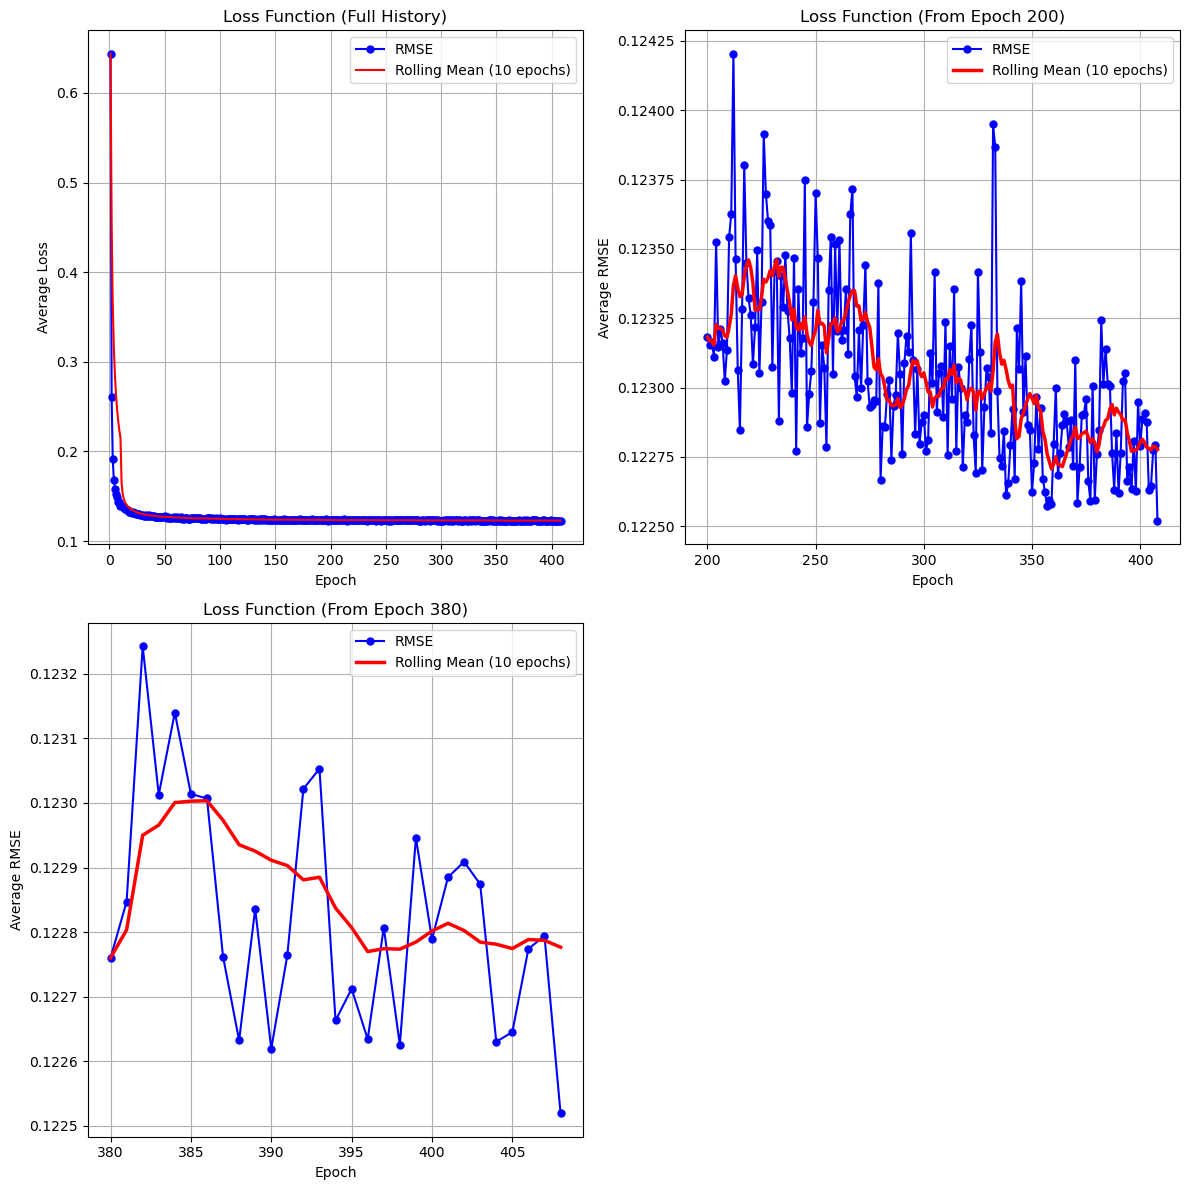

In [9]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[200, 380])
    
  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [10]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.122519


Как и видим, что большое количество параметров `572 млн` (`572 603 394`) не принесли значимого результата по сравнению с минимальным количеством параметров

### №2

In [11]:
# Пример использования
log_file = "logs/logs_09102024_1.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=1024, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Linear(in_features=4096, out_features=4096, bias=True)
(2): Linear(in_features=4096, out_features=8192, bias=True)
(3): Linear(in_features=8192, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=1024, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=1024, out_features=4096, bias=True)
(1): Identity()
(2): Linear(in_features=4096, out_features=8192, bias=True)
(3): Linear(in_features=8192, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=1024, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=1024, out_features=1024, bias=True)
(fc2): Linear(in_features=1024, out_features=1024, bias=True)
(relu): ReLU()
(norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)
(output_layer): Linear(in_features=1024, out_features=2, bias=True)

Total training time: 43140.0 seconds


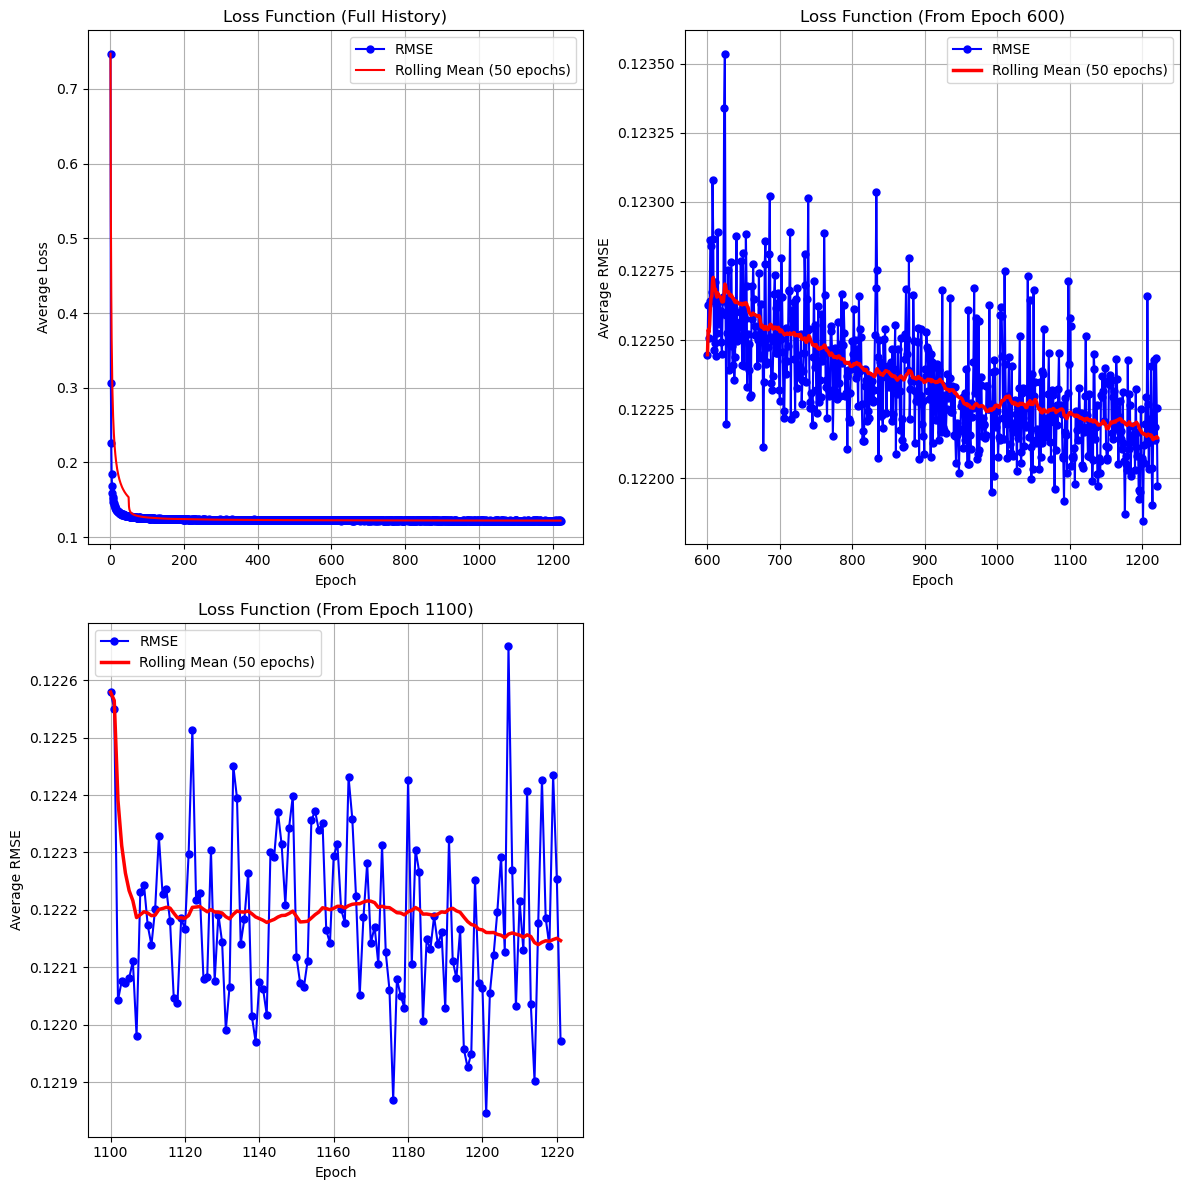

In [12]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[600, 1100], rolling_window=50)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [13]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.121846


Как и видим, что большое количество параметров `169 млн` (`169 917 442`) не принесли значимого результата по сравнению с минимальным количеством параметров

### №3

In [14]:
# Пример использования
log_file = "logs/logs_09102024_2.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=32, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2-4): 3 x Linear(in_features=128, out_features=128, bias=True)
(5): Linear(in_features=128, out_features=64, bias=True)
(6): Linear(in_features=64, out_features=32, bias=True)
(7): Linear(in_features=32, out_features=16, bias=True)
(8): Linear(in_features=16, out_features=8, bias=True)
(9): Linear(in_features=8, out_features=4, bias=True)
(10): Linear(in_features=4, out_features=2, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2-4): 3 x Identity()
(5): Linear(in_features=128, out_features=64, bias=True)
(6): Linear(in_features=64, out_features=32, bias=True)
(7): Linear(in_features=32, out_features=16, bias=True)
(8): Linear(in_features=16, out_featur

Total training time: 3093 seconds


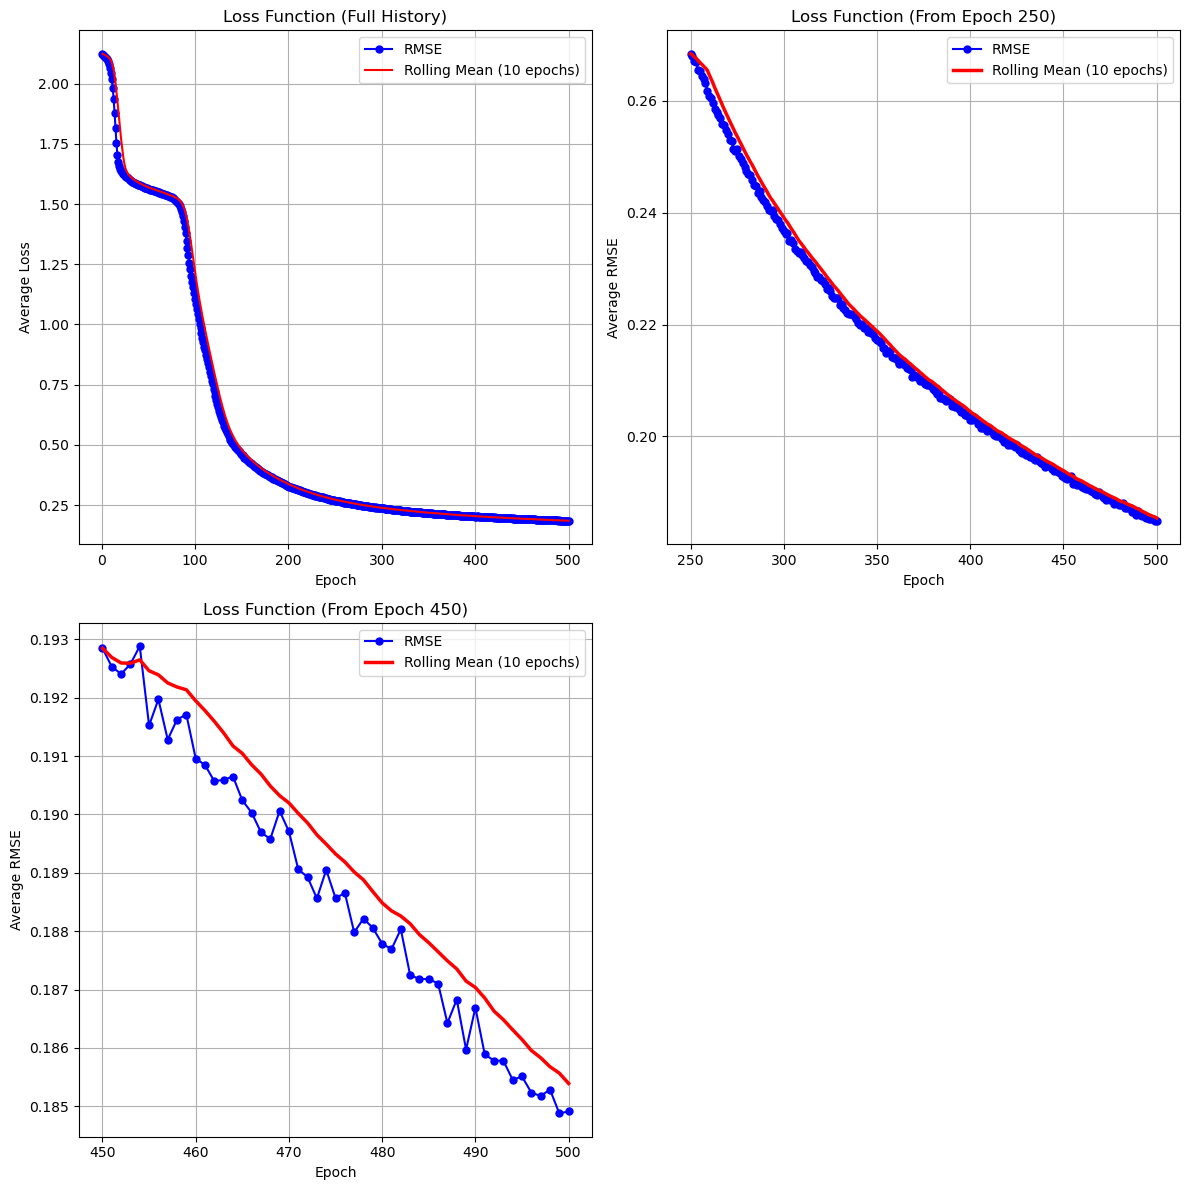

In [15]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[250, 450])

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [16]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.184879


Как и видим, что небольшое количество параметров `92 тыс` (`92 610`) не особо внушает качеством обучения

### №4

In [17]:
# Пример использования
log_file = "logs/logs_09102024_3.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=32, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2): Linear(in_features=128, out_features=128, bias=True)
(3): Linear(in_features=128, out_features=64, bias=True)
(4): Linear(in_features=64, out_features=32, bias=True)
(5): Linear(in_features=32, out_features=8, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=32, out_features=64, bias=True)
(1): Linear(in_features=64, out_features=128, bias=True)
(2): Identity()
(3): Linear(in_features=128, out_features=64, bias=True)
(4): Linear(in_features=64, out_features=32, bias=True)
(5): Linear(in_features=32, out_features=8, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=8, out_features=8, bias=True)
(fc2): Linear(in_features=8, out_features=8, bias=True)
(relu): ReLU()
(norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)
(out

Total training time: 3366 seconds


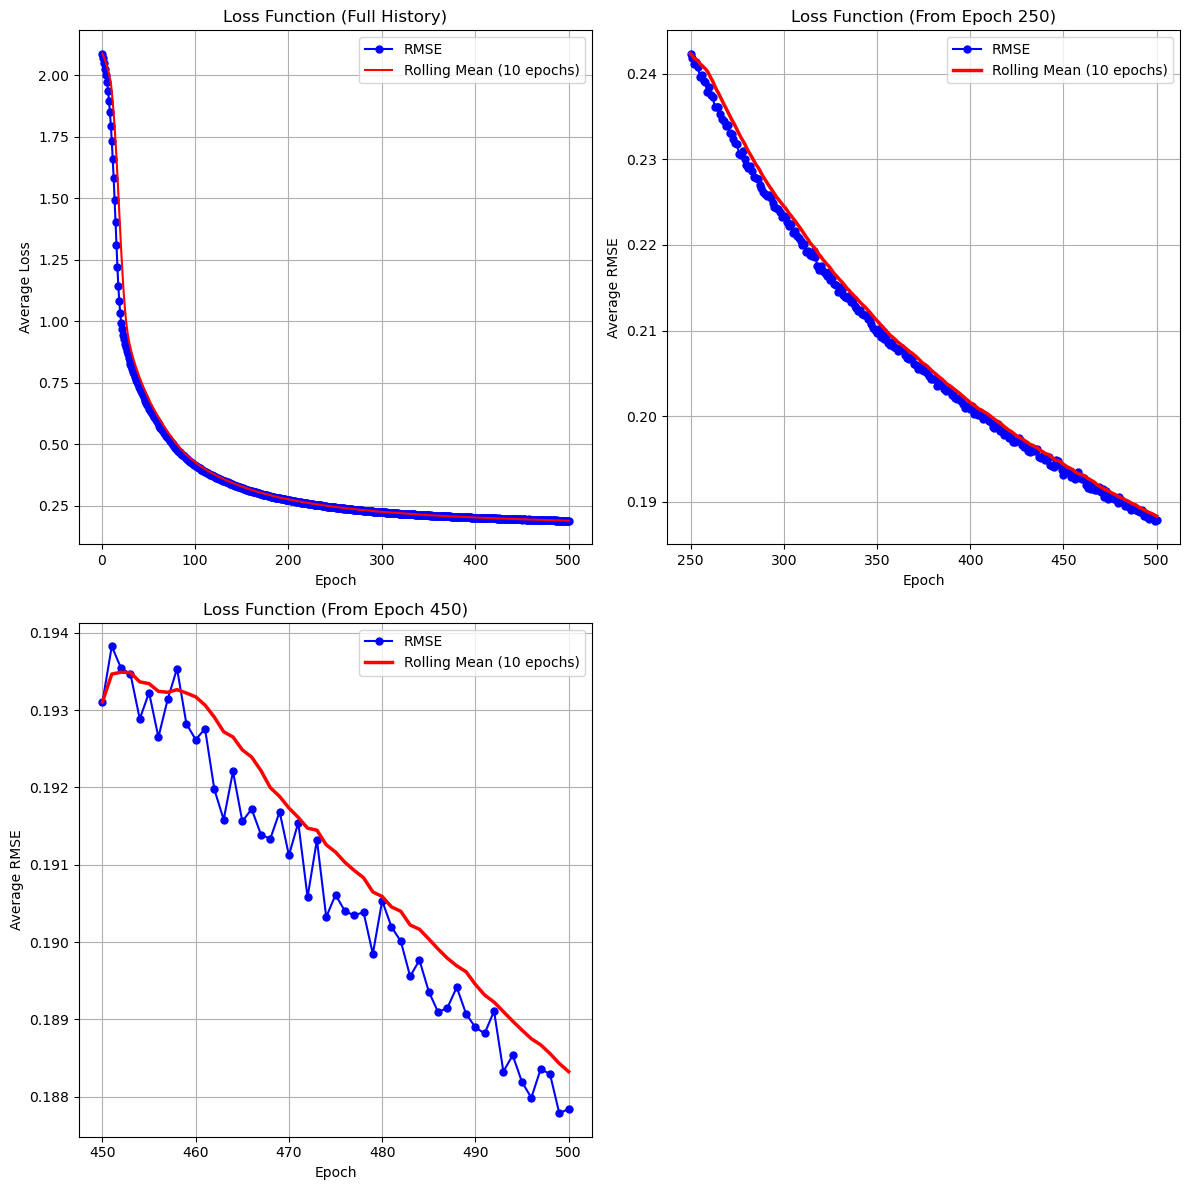

In [18]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[250, 450])

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [19]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.187783


Как и видим, что небольшое количество параметров `58 тыс` (`58 850`) также не принесли внушительного результата

### №5

In [20]:
# Пример использования
log_file = "logs/logs_09102024_4.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=128, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=128, out_features=256, bias=True)
(1): Linear(in_features=256, out_features=512, bias=True)
(2): Linear(in_features=512, out_features=256, bias=True)
(3-4): 2 x Linear(in_features=256, out_features=256, bias=True)
(5): Linear(in_features=256, out_features=128, bias=True)
(6): Linear(in_features=128, out_features=64, bias=True)
(7): Linear(in_features=64, out_features=32, bias=True)
(8): Linear(in_features=32, out_features=8, bias=True)
(9): Linear(in_features=8, out_features=4, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=128, out_features=256, bias=True)
(1): Linear(in_features=256, out_features=512, bias=True)
(2): Linear(in_features=512, out_features=256, bias=True)
(3-4): 2 x Identity()
(5): Linear(in_features=256, out_features=128, bias=True)
(6): Linear(in_features=128, out_features=64, bias=True)
(7): Linear(in_feature

Total training time: 15069.3 seconds


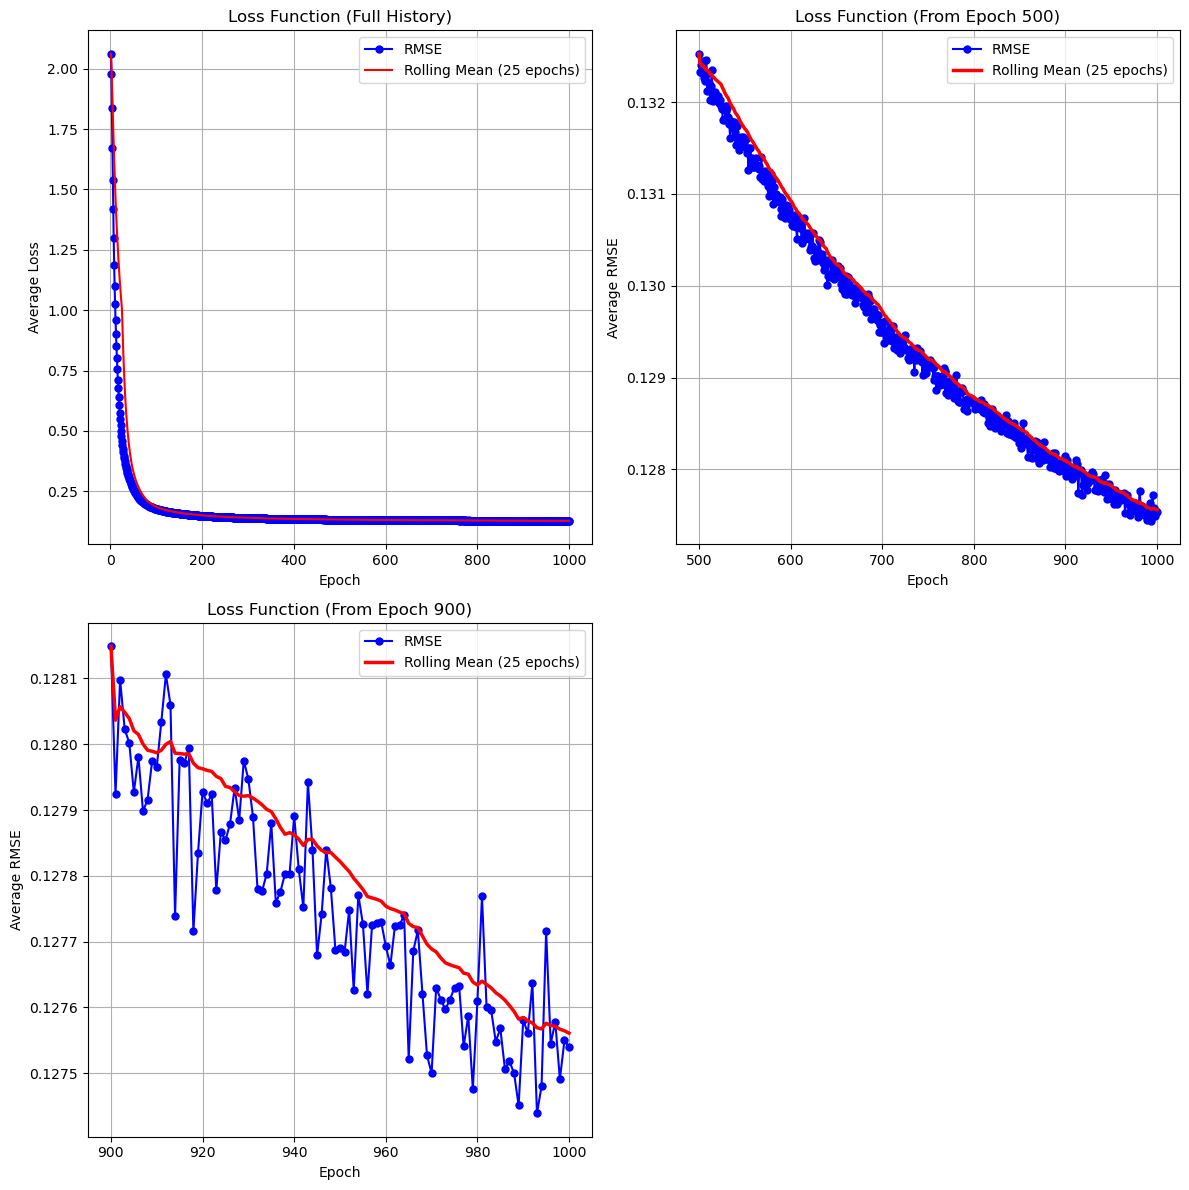

In [21]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[500, 900], rolling_window=25)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [22]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.127439


Как и видим, что небольшое количество параметров `810 тыс` (`810 962`) также не принесли внушительного результата

### №6

In [23]:
# Пример использования
log_file = "logs/logs_09102024_5.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=128, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=128, out_features=256, bias=True)
(1): Linear(in_features=256, out_features=512, bias=True)
(2): Linear(in_features=512, out_features=256, bias=True)
(3-4): 2 x Linear(in_features=256, out_features=256, bias=True)
(5): Linear(in_features=256, out_features=128, bias=True)
(6): Linear(in_features=128, out_features=64, bias=True)
(7): Linear(in_features=64, out_features=32, bias=True)
(8): Linear(in_features=32, out_features=32, bias=True)
(9): Linear(in_features=32, out_features=16, bias=True)
(10): Linear(in_features=16, out_features=4, bias=True)
(11): Linear(in_features=4, out_features=2, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=128, out_features=256, bias=True)
(1): Linear(in_features=256, out_features=512, bias=True)
(2): Linear(in_features=512, out_features=256, bias=True)
(3-4): 2 x Identity()
(5): Linear(in_features

Total training time: 14411.0 seconds


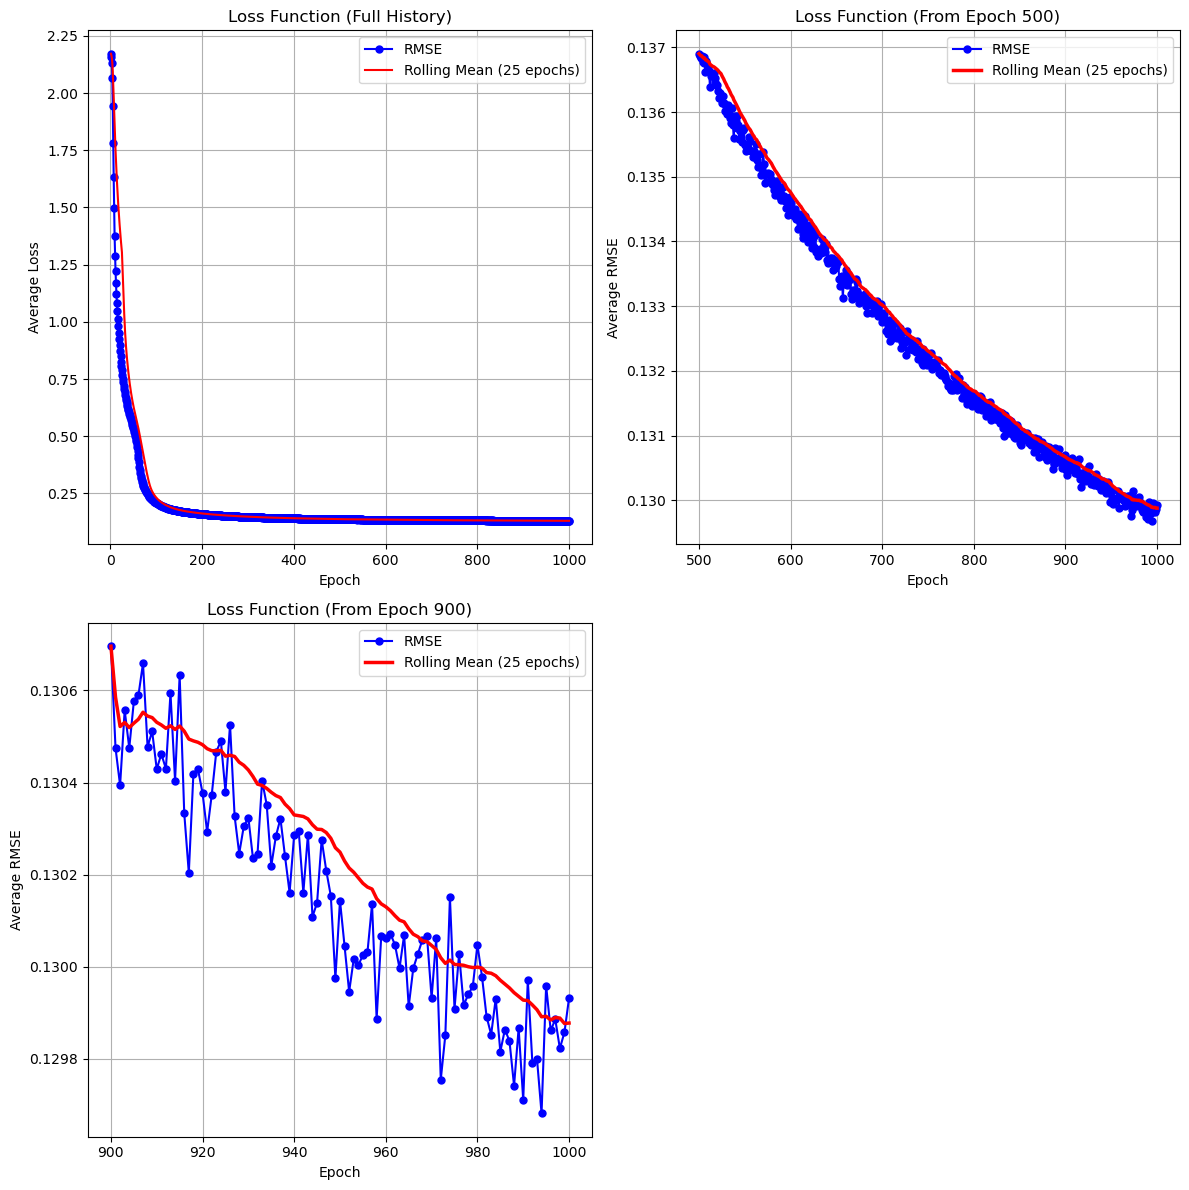

In [24]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[500, 900], rolling_window=25)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [25]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.129682


Как и видим, что небольшое количество параметров `812 тыс` (`812 594`) также не принесли внушительного результата

### №7

In [26]:
# Пример использования
log_file = "logs/logs_12102024.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=256, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=256, out_features=1024, bias=True)
(1): Linear(in_features=1024, out_features=2048, bias=True)
(2): Linear(in_features=2048, out_features=2048, bias=True)
(3): Linear(in_features=2048, out_features=256, bias=True)
(4): Linear(in_features=256, out_features=64, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=256, out_features=1024, bias=True)
(1): Linear(in_features=1024, out_features=2048, bias=True)
(2): Identity()
(3): Linear(in_features=2048, out_features=256, bias=True)
(4): Linear(in_features=256, out_features=64, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=64, out_features=64, bias=True)
(fc2): Linear(in_features=64, out_features=64, bias=True)
(relu): ReLU()
(norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)
(output_layer): Linear(in_features=64, out_features=2, bias=True)
(dropout): Dropout(p=0

Total training time: 43159.200000000004 seconds


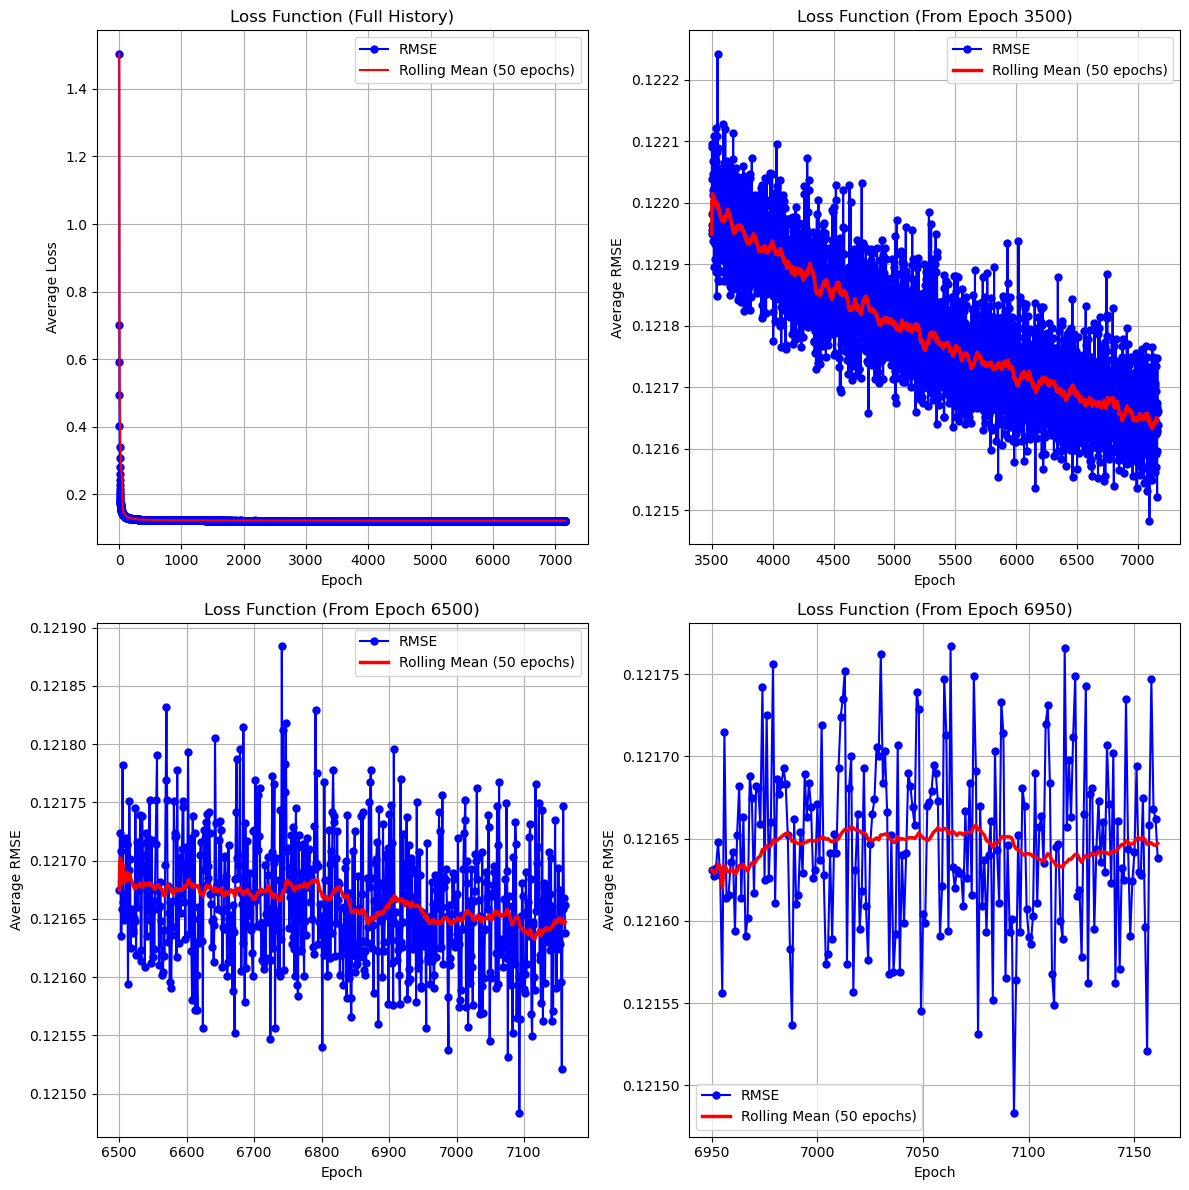

In [27]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[3500, 6500, 6950], rolling_window=50)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [28]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.121483


Как и видим, что большое количество параметров `10 млн` (`10 012 418`) также не принесли внушительного результата

### №8

In [29]:
# Пример использования
log_file = "logs/logs_12102024_1.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=64, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=64, out_features=512, bias=True)
(1): Linear(in_features=512, out_features=1024, bias=True)
(2): Linear(in_features=1024, out_features=2048, bias=True)
(3): Linear(in_features=2048, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=2048, bias=True)
(5): Linear(in_features=2048, out_features=1024, bias=True)
(6): Linear(in_features=1024, out_features=512, bias=True)
(7): Linear(in_features=512, out_features=64, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=64, out_features=512, bias=True)
(1): Linear(in_features=512, out_features=1024, bias=True)
(2): Linear(in_features=1024, out_features=2048, bias=True)
(3): Linear(in_features=2048, out_features=4096, bias=True)
(4): Linear(in_features=4096, out_features=2048, bias=True)
(5): Linear(in_features=2048, out_features=1024, bias=True)
(6): Linear(in_features=

Total training time: 10652.7 seconds


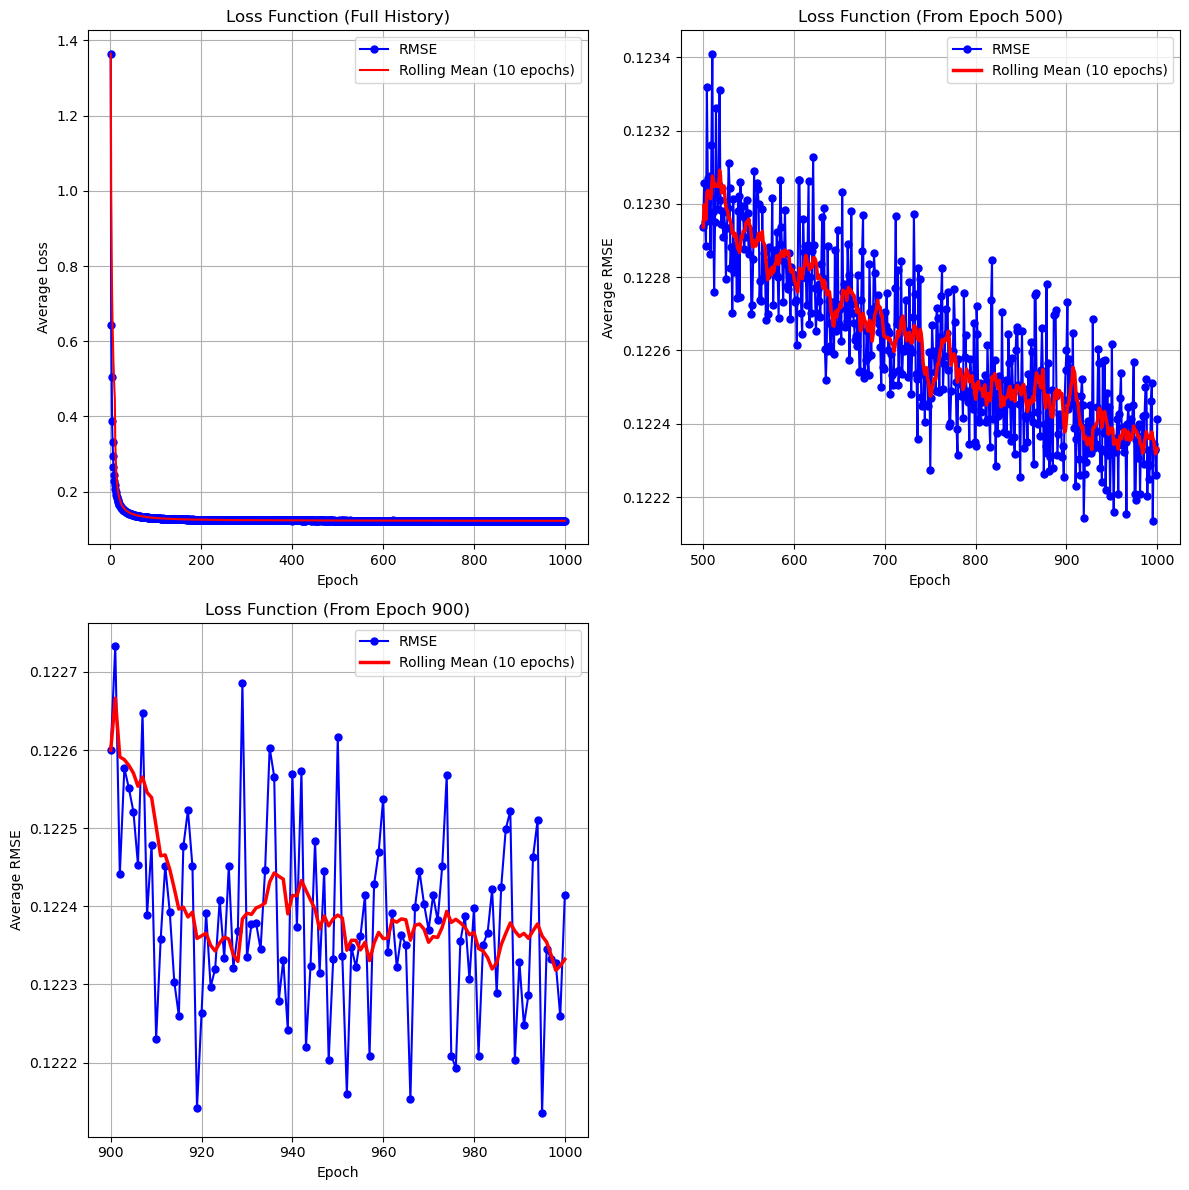

In [30]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[500, 900], rolling_window=10)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [31]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.122135


Как и видим, что большое количество параметров `44 млн` (`44 202 690`) также не принесли внушительного результата

### №9

In [32]:
# Пример использования
log_file = "logs/logs_12102024_2.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=256, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=256, out_features=1024, bias=True)
(1): Linear(in_features=1024, out_features=2048, bias=True)
(2): Linear(in_features=2048, out_features=2048, bias=True)
(3): Linear(in_features=2048, out_features=256, bias=True)
(4): Linear(in_features=256, out_features=64, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=256, out_features=1024, bias=True)
(1): Linear(in_features=1024, out_features=2048, bias=True)
(2): Identity()
(3): Linear(in_features=2048, out_features=256, bias=True)
(4): Linear(in_features=256, out_features=64, bias=True)
)
(ode_func): ODEFunc(
(fc1): Linear(in_features=64, out_features=64, bias=True)
(fc2): Linear(in_features=64, out_features=64, bias=True)
(relu): ReLU()
(norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)
(output_layer): Linear(in_features=64, out_features=2, bias=True)
(dropout): Dropout(p=0

Total training time: 5634.2 seconds


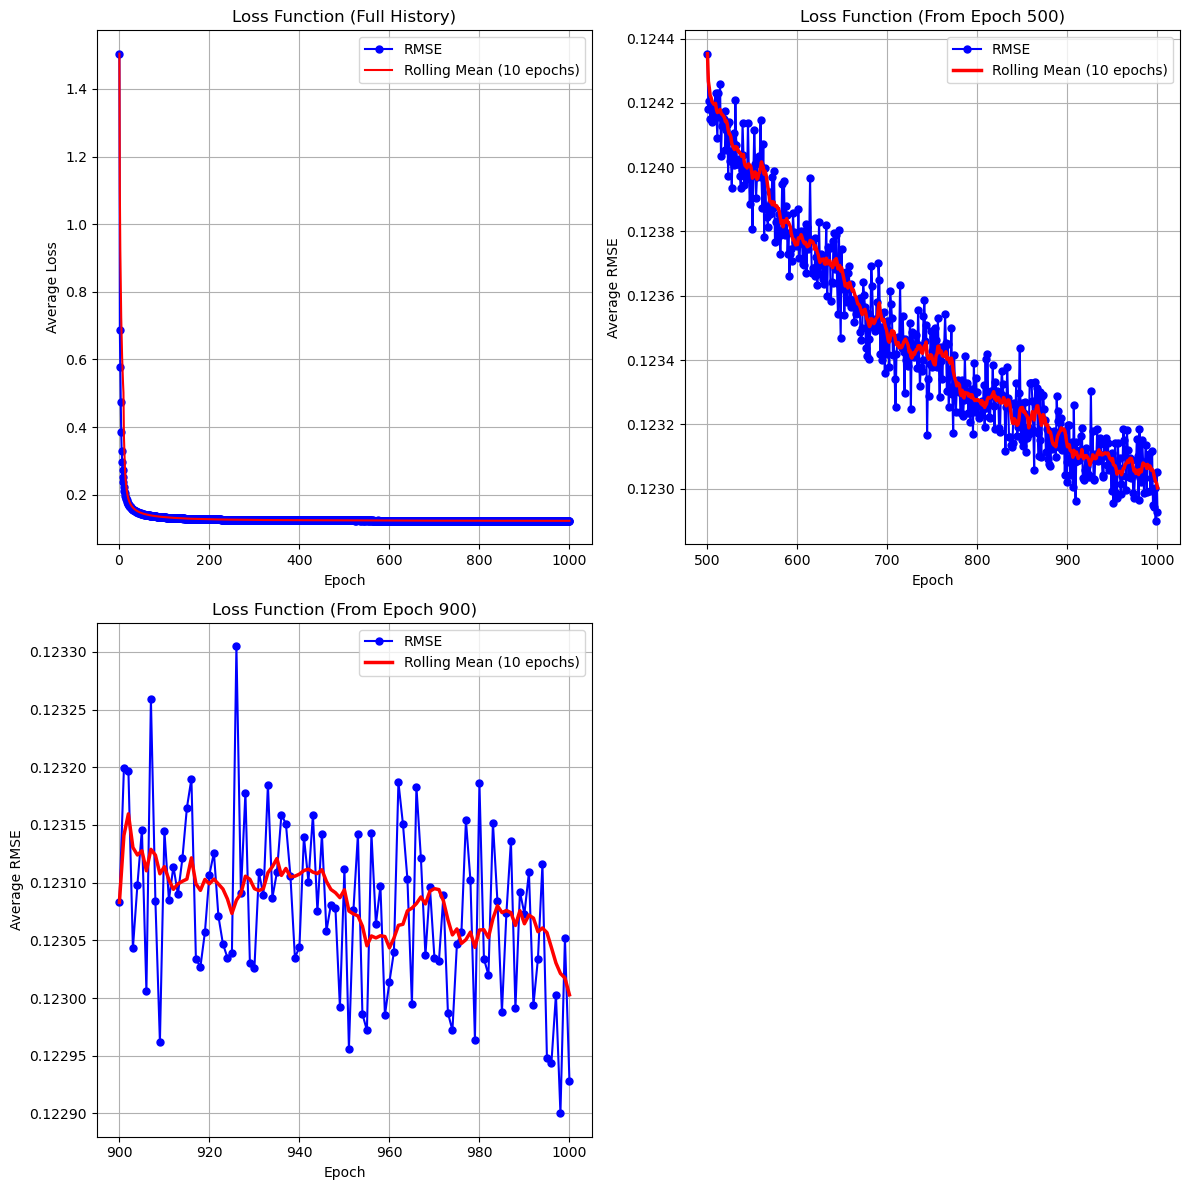

In [33]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[500, 900], rolling_window=10)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [34]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.1229


Как и видим, что большое количество параметров `10 млн` (`10 012 418`) также не принесли внушительного результата

### №10

In [35]:
# Пример использования
log_file = "logs/logs_12102024_3.log"
architecture = parse_model_architecture(log_file)
parameters = parse_model_parameters(log_file)
df_history, total_training_time = parse_training_history(log_file)

if architecture:
  print(architecture)
else:
  print("Архитектура модели не найдена в файле лога.")

for param_name, param_info in parameters.items():
  if param_name == 'total_parameters':
    print(f"Total trainable parameters: {param_info}")
    total_param = param_info
  else:
    print(f"Parameter name: {param_name}")
    print(f"  Shape: {param_info['shape']}")
    print(f"  Count: {param_info['count']}")
    print("-" * 20)

NeuralODEModel(
(input_layer): Linear(in_features=2, out_features=64, bias=True)
(hidden_layers): ModuleList(
(0): Linear(in_features=64, out_features=128, bias=True)
(1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
(3): Linear(in_features=128, out_features=256, bias=True)
(4): Linear(in_features=256, out_features=256, bias=True)
(5): Linear(in_features=256, out_features=128, bias=True)
(6): Linear(in_features=128, out_features=64, bias=True)
(7): Linear(in_features=64, out_features=32, bias=True)
(8): Linear(in_features=32, out_features=32, bias=True)
(9): Linear(in_features=32, out_features=16, bias=True)
(10): Linear(in_features=16, out_features=4, bias=True)
(11): Linear(in_features=4, out_features=2, bias=True)
)
(residual_connections): ModuleList(
(0): Linear(in_features=64, out_features=128, bias=True)
(1-2): 2 x Identity()
(3): Linear(in_features=128, out_features=256, bias=True)
(4): Identity()
(5): Linear(in_features=256, out_features=128, bias=True)
(6): Linea

Total training time: 4280.200000000001 seconds


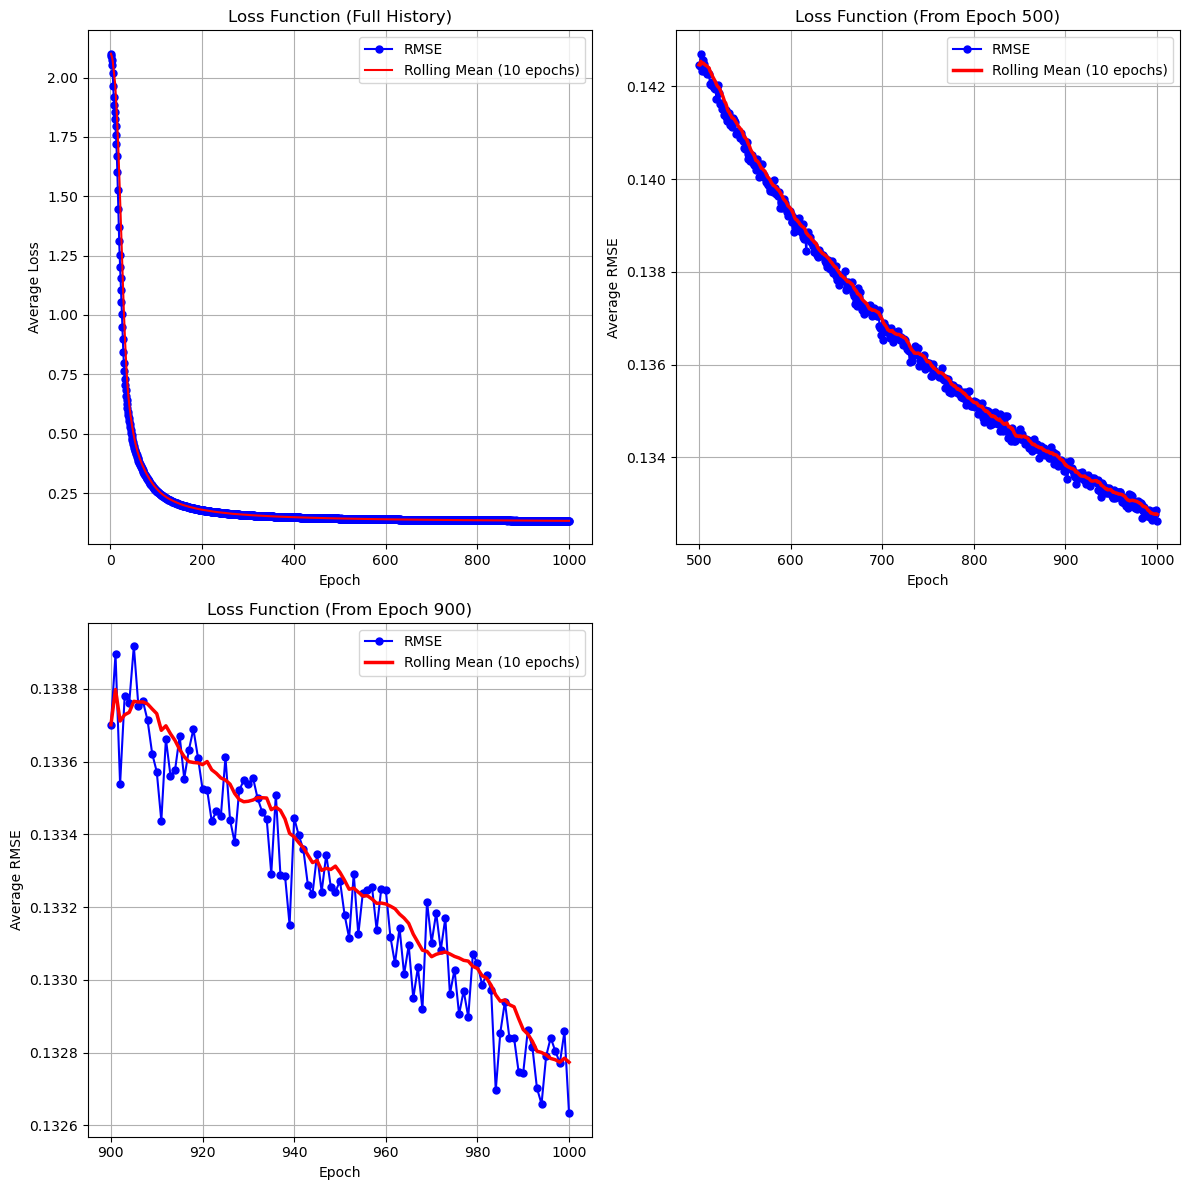

In [36]:
if df_history is not None:
  # print(df_history)
  print(f"Total training time: {total_training_time} seconds")
  plot_training_history(df_history, start_epochs=[500, 900], rolling_window=10)

  # Добавление информации в df_results
  new_row = {
      'Total parameters': total_param, 
      'RMSE': df_history.RMSE.min(), 
      'Training time (s)': total_training_time
  }  
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)
else:
  print("История обучения не найдена в файле лога.")

In [37]:
print(f'Самая минимальная RMSE: {df_history.RMSE.min()}')

Самая минимальная RMSE: 0.132633


Как и видим, что небольшое количество параметров `270 тыс` (`270 450`) также не принесли внушительного результата

## Результаты

In [38]:
df_results

,Total parameters,RMSE,Training time (s)
0,572603394,0.122519,43152.0
1,169917442,0.121846,43140.0
2,92610,0.184879,3093.0
3,58850,0.187783,3366.0
4,810962,0.127439,15069.3
5,812594,0.129682,14411.0
6,10012418,0.121483,43159.2
7,44202690,0.122135,10652.7
8,10012418,0.122900,5634.2
9,270450,0.132633,4280.2


### Вычисление рейтинга

In [39]:
# Вычисление рейтинга в одну строку
df_results['Rating'] = (
    0.8 * (df_results['RMSE'] - df_results['RMSE'].min()) / (df_results['RMSE'].max() - df_results['RMSE'].min()) +
    0.05 * (df_results['Training time (s)'] - df_results['Training time (s)'].min()) / (df_results['Training time (s)'].max() - df_results['Training time (s)'].min()) +
    0.15 * (df_results['Total parameters'] - df_results['Total parameters'].min()) / (df_results['Total parameters'].max() - df_results['Total parameters'].min())
)

# Сортировка по рейтингу в порядке убывания
df_results = df_results.sort_values(by='Rating', ascending=False)

In [42]:
df_results

,Total parameters,RMSE,Training time (s),Rating
3,58850,0.187783,3366.0,0.800341
2,92610,0.184879,3093.0,0.764968
0,572603394,0.122519,43152.0,0.212492
9,270450,0.132633,4280.2,0.136077
5,812594,0.129682,14411.0,0.113254
1,169917442,0.121846,43140.0,0.098857
4,810962,0.127439,15069.3,0.087010
6,10012418,0.121483,43159.2,0.052608
7,44202690,0.122135,10652.7,0.028866
8,10012418,0.122900,5634.2,0.022877


В результате анализа рейтингов моделей можно сделать вывод, что даже при большом весе метрики RMSE и количества параметров, время на обучение модели не всегда оказывает значительное влияние на итоговый рейтинг.

Удивительно, но модель с наименьшим количеством параметров и большим значением RMSE может занимать первое место по рейтингу. Это объясняется тем, что такая модель может иметь лучшее соотношение значений RMSE, общего количества параметров и времени на обучение.

Таким образом, нет необходимости создавать сложные архитектуры моделей, которые требуют много времени на обучение и дают посредственные результаты по метрике RMSE. Вместо этого можно упростить архитектуру и быстро обучить модель, получив при этом приемлемые результаты. В дальнейшем можно дообучить модель и улучшить метрику RMSE.

Второе место в рейтинге также занимает модель с наименьшим количеством параметров и быстрым обучением. Это подтверждает гипотезу о том, что простота архитектуры и быстрое обучение могут быть более эффективными, чем сложная архитектура и длительное обучение.